# The discretization of gradient descend flow

## Import library and setup dependency

#### Universal library

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 3 decimal places, no scientific notation
np.set_printoptions(precision=3, suppress=True)

#### Customize library

In [8]:
import os
import sys

# Set project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ''))
sys.path.append(project_root)

print(f"current: {os.getcwd()}")
print(f"root   : {project_root}")

current: c:\Users\BTCOM\Desktop\0_Project\DeepLearning\hessian-optimizer-comparison
root   : c:\Users\BTCOM\Desktop\0_Project\DeepLearning\hessian-optimizer-comparison


In [9]:
from custom_library.utils import dataUtils
import custom_library.models as my_models

# Set autoreload for external modules change
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize Model

---
### Explicit Gradient Descend (Normal Gradeint Descend)
- The linear approximation 


- Taylor: $L(\theta) = L(\theta_0) + \nabla L(\theta_0)(\Delta \theta)$


Final: $\theta_{k+1} = \theta_k - \eta \nabla L(\theta_k)$

In [10]:
ExplicitModel = my_models.ExplicitLrModel

---
### Implicit Gradient Descend (Backward euler on quadratic):
- The quadratic approximation


- Taylor: $L(\theta) = L(\theta_0) + \nabla L(\theta_0)(\Delta \theta) + \frac{1}{2} (\Delta \theta)^T \nabla^2 L(\theta_0)(\Delta \theta)$


- $\theta_{k+1} = \theta_k - \eta \nabla L(\theta_{k+1})$


Final: $\theta_{k+1} = (I + \eta H)^-1 (\theta_k + \eta b)$

In [11]:
ImplicitModel = my_models.ImplicitLrModel

---
### Newton Gradient Descend (Newton's method):
- The quadratic approximation, jump to optimum (vertex)


- Taylor: $L(\theta) = L(\theta_0) + \nabla L(\theta_0)(\Delta \theta) + \frac{1}{2} (\Delta \theta)^T \nabla^2 L(\theta_0)(\Delta \theta)$


- $\nabla L (\theta) = \Delta L (\theta_0) + H(\Delta \theta)$


- $0 = \Delta L (\theta_0) + H(\Delta \theta)$


Final: $\theta_{k+1} = \theta_{k} - H^-1 \Delta L (\theta_k)$

In [43]:
# Using optimize because default newton is too sensitive to data that has not been cleaned
NewtonModel = my_models.OptimizeNewtonLrModel

## Systhesis DataSets

In [13]:
sample_dim = 4000
input_dim = 2
output_dim = 1
split_ration = 0.8

# Generate some linear sample_dim data
# linear [sample_dim_dim, 1]
linear = np.linspace(-1, 1, sample_dim).reshape(-1, 1)

# z [sample_dim, output_dim]
y_true = np.pow(linear+0.2,5)*0.5 + np.pow(linear-0.1, 1)*0.3 + np.pow(linear,3)*np.random.rand(sample_dim,output_dim)*0.1

y_true = np.abs(y_true)

# X [sample_dim, input_dim]
X = np.column_stack((linear, np.pow(linear, 3))).reshape(sample_dim, input_dim)+ np.random.rand(sample_dim,input_dim)*0.1

# Split dataset
X_train, y_train, X_eval, y_eval = dataUtils.split_data(X, y_true, split_ration)
y_pred = np.random.rand(y_eval.shape[0], y_eval.shape[1])

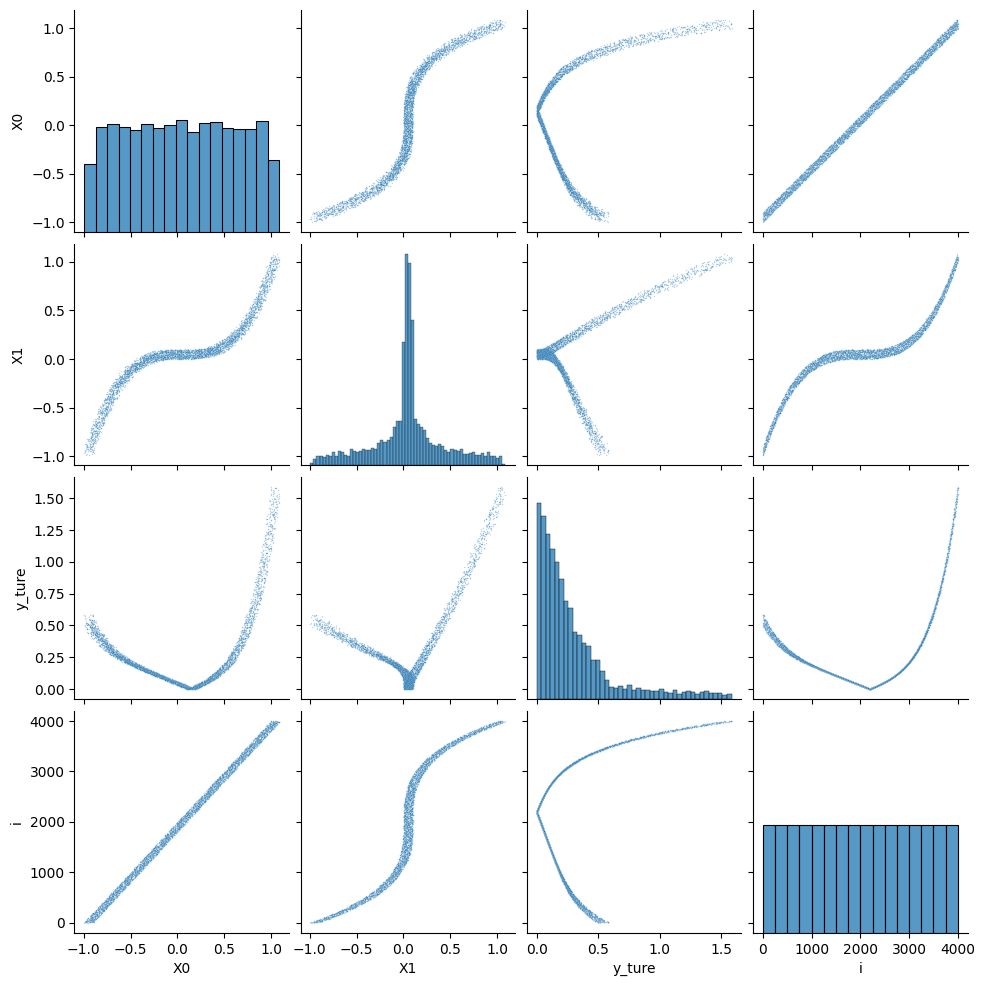

In [14]:
# make the pairplot
i = np.arange(1, X.shape[0]+1)

df = pd.DataFrame(X, columns=[f"X{i}" for i in range(X.shape[1])])
df["y_ture"] = y_true if y_true.ndim == 1 else y_true[:,0]
df["i"] = i

sns.pairplot(df,  plot_kws={"alpha": 0.3, "s": 1})

## Initialize Dense and Activity layers

### Initial new weight

In [15]:
baseModel = my_models.ImplicitLrModel()
baseModel.add(50, input_shape=2)
baseModel.add(30, activation="relu")
baseModel.add(10, activation="relu")
baseModel.add(10, activation="relu")
baseModel.add(5)
baseModel.add(1) 

### Rollback weight to origin point

In [16]:
explicitModel = ExplicitModel()
implicitModel = ImplicitModel()
newtonModel = NewtonModel()

In [17]:
models = [explicitModel, implicitModel, newtonModel]

In [38]:
newtonModel = NewtonModel()

In [18]:
## Make all models start at the same position
baseLayers = baseModel.layers

# baseLayers = saveModel.layers

for model in models:
    model.copylayers(baseLayers)

In [39]:
newtonModel.copylayers(baseLayers)

## Train Models

### Control

In [19]:
epochs = 10
batch_size = 64

### Train Explicit GD

In [20]:
explicitModel_history = explicitModel.fit(X_train, y_train, X_eval, y_eval, epochs=epochs, batch_size=batch_size, learning_rate=0.01)

Epoch 1/10 [=........................], 0/3200: 
batch: 0.143, acc: 0.155, val: 0.148
Epoch 1/10 [=........................], 64/3200: 
batch: 0.131, acc: 0.150, val: 0.142
Epoch 1/10 [=........................], 128/3200: 
batch: 0.122, acc: 0.141, val: 0.133
Epoch 1/10 [=........................], 192/3200: 
batch: 0.146, acc: 0.135, val: 0.127
Epoch 1/10 [=........................], 256/3200: 
batch: 0.127, acc: 0.129, val: 0.120
Epoch 1/10 [=........................], 320/3200: 
batch: 0.109, acc: 0.121, val: 0.112
Epoch 1/10 [=........................], 384/3200: 
batch: 0.136, acc: 0.118, val: 0.110
Epoch 1/10 [=........................], 448/3200: 
batch: 0.106, acc: 0.115, val: 0.106
Epoch 1/10 [=........................], 512/3200: 
batch: 0.129, acc: 0.111, val: 0.102
Epoch 1/10 [=........................], 576/3200: 
batch: 0.106, acc: 0.108, val: 0.100
Epoch 1/10 [=........................], 640/3200: 
batch: 0.140, acc: 0.108, val: 0.100
Epoch 1/10 [=......................

### Train Implicit GD

In [21]:
implicitModel_history = implicitModel.fit(X_train, y_train, X_eval, y_eval, epochs=epochs, batch_size=batch_size, learning_rate=0.05)

Epoch 1/10 [=........................], 0/3200: 
batch: 0.125, acc: 0.135, val: 0.127
Epoch 1/10 [=........................], 64/3200: 
batch: 0.107, acc: 0.119, val: 0.111
Epoch 1/10 [=........................], 128/3200: 
batch: 0.093, acc: 0.104, val: 0.096
Epoch 1/10 [=........................], 192/3200: 
batch: 0.101, acc: 0.094, val: 0.086
Epoch 1/10 [=........................], 256/3200: 
batch: 0.081, acc: 0.088, val: 0.081
Epoch 1/10 [=........................], 320/3200: 
batch: 0.076, acc: 0.085, val: 0.077
Epoch 1/10 [=........................], 384/3200: 
batch: 0.097, acc: 0.082, val: 0.076
Epoch 1/10 [=........................], 448/3200: 
batch: 0.077, acc: 0.080, val: 0.073
Epoch 1/10 [=........................], 512/3200: 
batch: 0.088, acc: 0.077, val: 0.072
Epoch 1/10 [=........................], 576/3200: 
batch: 0.077, acc: 0.076, val: 0.070
Epoch 1/10 [=........................], 640/3200: 
batch: 0.095, acc: 0.082, val: 0.077
Epoch 1/10 [=......................

### Train Newton GD

In [44]:
newtonModel_history = newtonModel.fit(X_train, y_train, X_eval, y_eval, epochs=epochs, batch_size=batch_size, damping_factor=1e-4)

Epoch 1/10 [=........................], 0/3200: 
batch: 0.142, acc: 0.159, val: 0.151
Epoch 1/10 [=........................], 64/3200: 
batch: 0.119, acc: 0.150, val: 0.142
Epoch 1/10 [=........................], 128/3200: 
batch: 0.112, acc: 0.118, val: 0.114
Epoch 1/10 [=........................], 192/3200: 
batch: 0.105, acc: 0.108, val: 0.104
Epoch 1/10 [=........................], 256/3200: 
batch: 0.136, acc: 0.113, val: 0.113
Epoch 1/10 [=........................], 320/3200: 
batch: 0.107, acc: 0.096, val: 0.097
Epoch 1/10 [=........................], 384/3200: 
batch: 0.094, acc: 0.096, val: 0.098
Epoch 1/10 [=........................], 448/3200: 
batch: 0.075, acc: 0.078, val: 0.080
Epoch 1/10 [=........................], 512/3200: 
batch: 0.091, acc: 0.078, val: 0.080
Epoch 1/10 [=........................], 576/3200: 
batch: 0.067, acc: 0.074, val: 0.076
Epoch 1/10 [=........................], 640/3200: 
batch: 0.068, acc: 0.065, val: 0.065
Epoch 1/10 [=......................

## Evaluate Models

In [45]:
history = [explicitModel.getHistory(), implicitModel.getHistory(), newtonModel.getHistory()]

### loss/batch

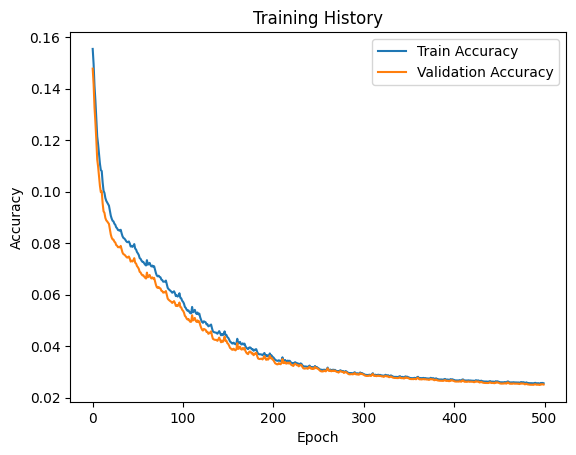

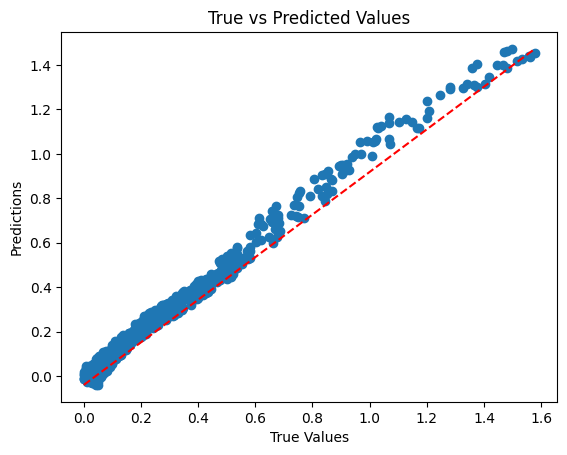

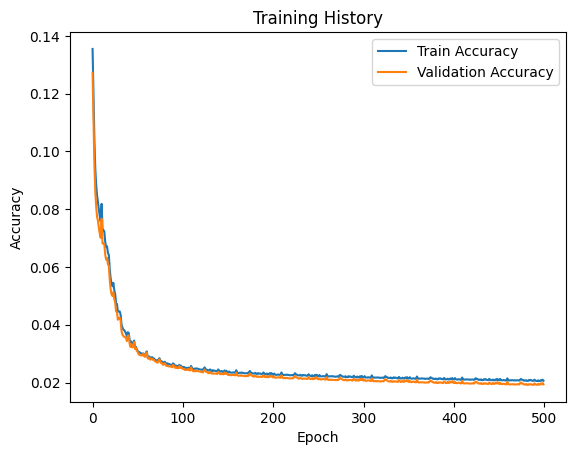

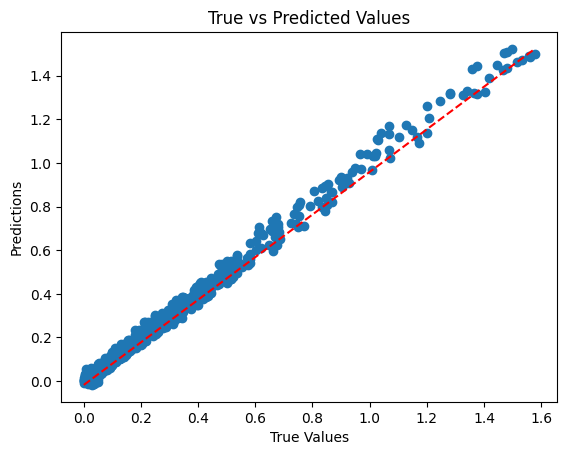

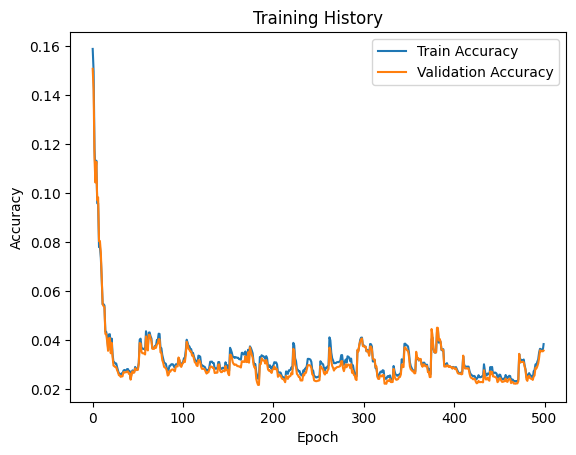

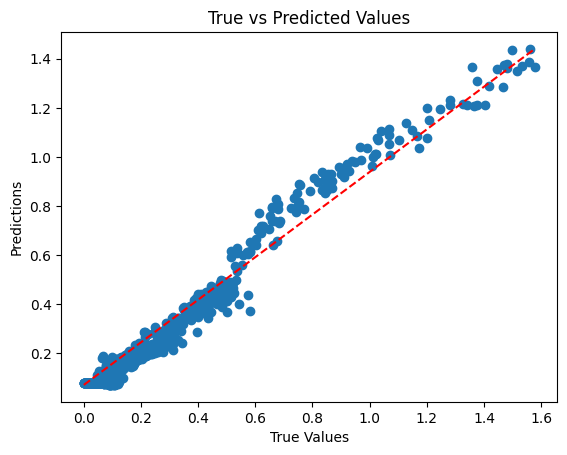

In [46]:
for h in history:
    h.evaluate()

## Compare Rate

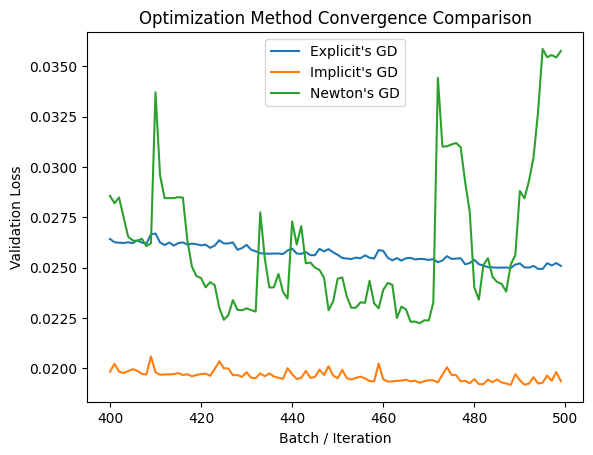

In [ ]:
label = ["Explicit's GD", "Implicit's GD", "Newton's GD"]

start = 400
end = len(hist_arr)

for i, h in enumerate(history):
    if i == 1:
        break
    hist_arr = np.array(h.history)

    x = [i for i in range(start, end, 1)]
    train_acc = hist_arr[start:end, 0]
    val_acc = hist_arr[start:end, 1]

    plt.plot(x, val_acc, label=f'{label[i]}')
    plt.xlabel('Batch / Iteration')
    plt.ylabel('Validation Loss') # Or Training Loss, depending on what hist_arr[:, 1] represents
    plt.title('Optimization Method Convergence Comparison') 
    plt.legend()
plt.show()

### Predict trend

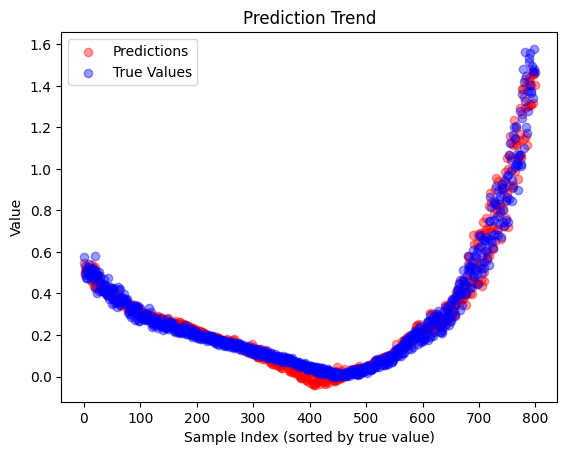

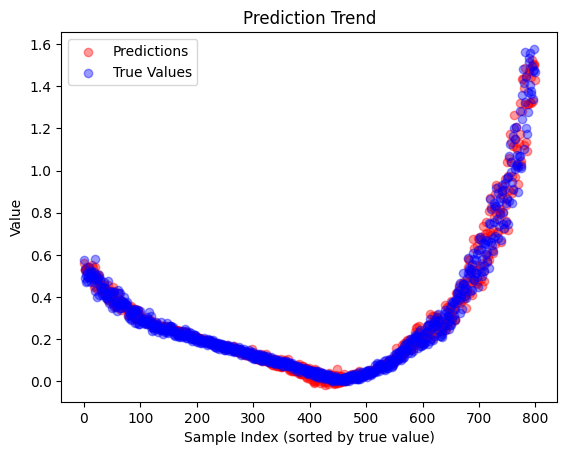

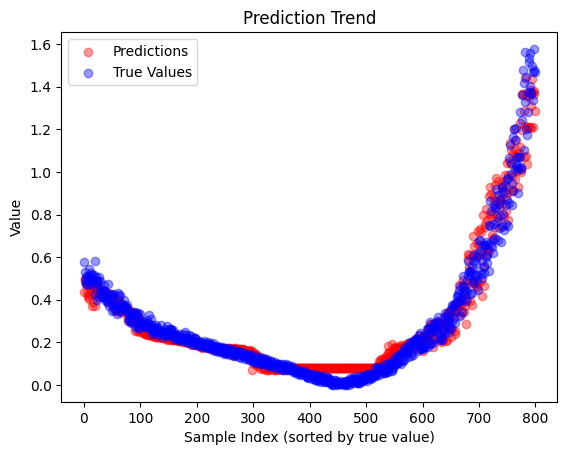

In [50]:
for h in history:
    h.display_trend()

# Other

In [62]:
import pickle
import datetime

now = datetime.datetime.now()
time_stamp = now.strftime("%d%m%Y_%H%M%S")

name = ['explicit', 'implicit', 'newton']
file_name = 'modele.pkl'

for i,model in enumerate(models):
    # Open the file in binary write mode ('wb')
    with open(f'model_saves/{time_stamp}_{name[i]}_{file_name}', 'wb') as file:
        # Use pickle.dump(object, file_handle)
        pickle.dump(model, file)

datas = [X_train, y_train, X_eval, y_eval]
name = ['X_train', 'y_train', 'X_eval', 'y_eval']
file_name = 'dataset.pkl'

for i,data in enumerate(datas):
    # Open the file in binary write mode ('wb')
    with open(f'model_saves/{time_stamp}_{name[i]}_{file_name}', 'wb') as file:
        # Use pickle.dump(object, file_handle)
        pickle.dump(data, file)

print(f"Class instance saved to {file_name}")

Class instance saved to dataset.pkl


In [231]:
import copy

saveModel = copy.deepcopy(baseModel)
saveModel

### Explicit GD

#### Setup LR models class

In [ ]:
model = my_models.ExplicitLrModel()

test


In [ ]:
model.add(50, input_shape=2)
model.add(30, activation="relu")
model.add(10, activation="relu")
model.add(10, activation="relu")
model.add(5)
model.add(1)

In [95]:
model.total_params()

2161

#### Load dataset

In [96]:
sample_dim = 4000
input_dim = 2
output_dim = 1
split_ration = 0.8

# Generate some linear sample_dim data
# linear [sample_dim_dim, 1]
linear = np.linspace(-1, 1, sample_dim).reshape(-1, 1)

# z [sample_dim, output_dim]
y_true = np.pow(linear,5)*0.5 + np.pow(linear, 1)*0.3 + np.pow(linear,3)*np.random.rand(sample_dim,output_dim)*0.1

y_true = np.abs(y_true)

# X [sample_dim, input_dim]
X = np.column_stack((linear, np.pow(linear, 3))).reshape(sample_dim, input_dim)+ np.random.rand(sample_dim,input_dim)*0.1

# Split dataset
X_train, y_train, X_eval, y_eval = dataUtils.split_data(X, y_true, split_ration)
y_pred = np.random.rand(y_eval.shape[0], y_eval.shape[1])


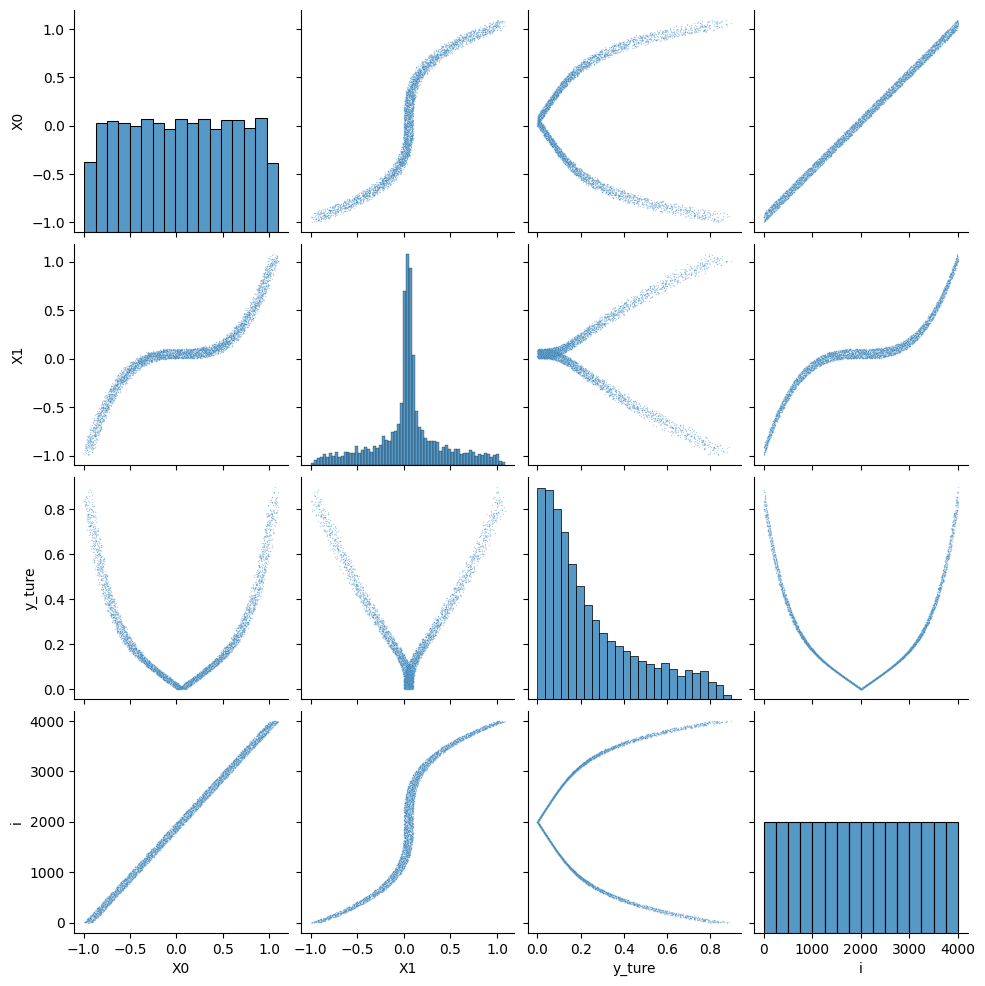

In [97]:
# put your inputs and outputs together in one DataFrame
i = np.arange(1, X.shape[0]+1)

df = pd.DataFrame(X, columns=[f"X{i}" for i in range(X.shape[1])])
df["y_ture"] = y_true if y_true.ndim == 1 else y_true[:,0]
df["i"] = i

# make the pairplot
sns.pairplot(df,  plot_kws={"alpha": 0.3, "s": 1})

#### Train Model

In [ ]:
history = model.fit(X_train, y_train, X_eval, y_eval, epochs=5, batch_size=256, learning_rate=0.0001)

Epoch 1/5 [=........................]
loss: nan, val_loss: nan

Epoch 2/5 [======...................]
loss: nan, val_loss: nan

Epoch 3/5 [===========..............]
loss: nan, val_loss: nan

Epoch 4/5 [================.........]
loss: nan, val_loss: nan

Epoch 5/5 [=====================....]
loss: nan, val_loss: nan

best-loss: 0.0144


#### Evaluate Model

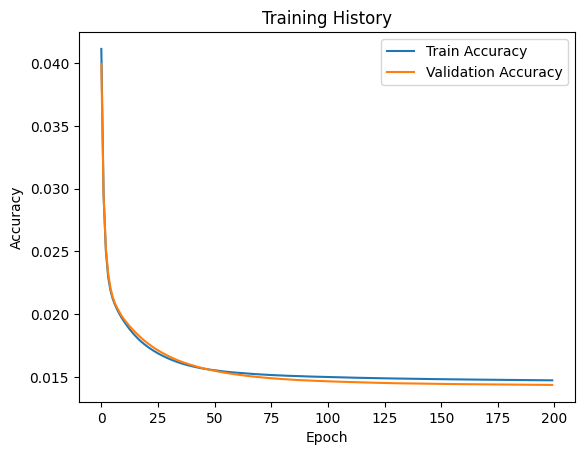

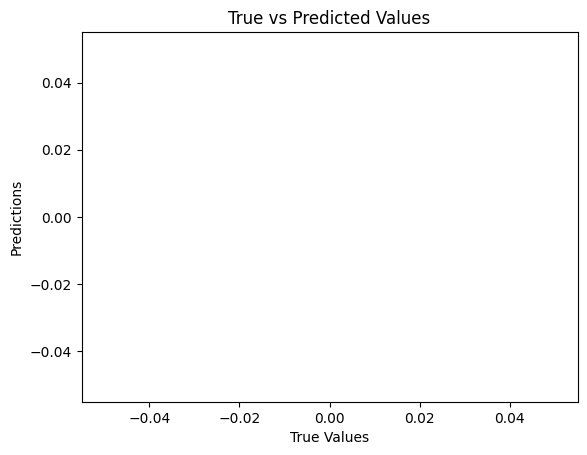

In [113]:
history.evaluate()

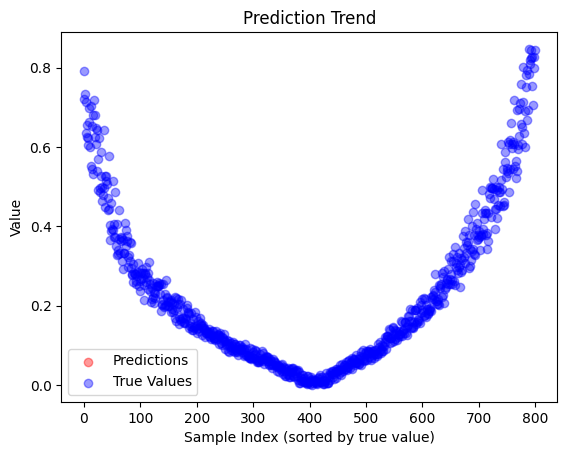

In [114]:
history.display_trend(ref="x", axis=0)

### Implicit GD

#### Setup LR models class

In [628]:
model = my_models.ImplicitLrModel()

test


In [629]:
model.add(50, input_shape=2)
model.add(30, activation="relu")
model.add(10, activation="relu")
model.add(10, activation="relu")
model.add(5)
model.add(1)

In [630]:
model.total_params()

2161

#### Load dataset

In [631]:
sample_dim = 4000
input_dim = 2
output_dim = 1
split_ration = 0.8

# Generate some linear sample_dim data
# linear [sample_dim_dim, 1]
linear = np.linspace(-1, 1, sample_dim).reshape(-1, 1)

# z [sample_dim, output_dim]
y_true = np.pow(linear,5)*0.5 + np.pow(linear, 1)*0.3 + np.pow(linear,2)*np.random.rand(sample_dim,output_dim)*0.1

y_true = np.abs(y_true)

# X [sample_dim, input_dim]
X = np.column_stack((linear, np.pow(linear, 3))).reshape(sample_dim, input_dim)+ np.random.rand(sample_dim,input_dim)*0.1

# Split dataset
X_train, y_train, X_eval, y_eval = dataUtils.split_data(X, y_true, split_ration)
y_pred = np.random.rand(y_eval.shape[0], y_eval.shape[1])


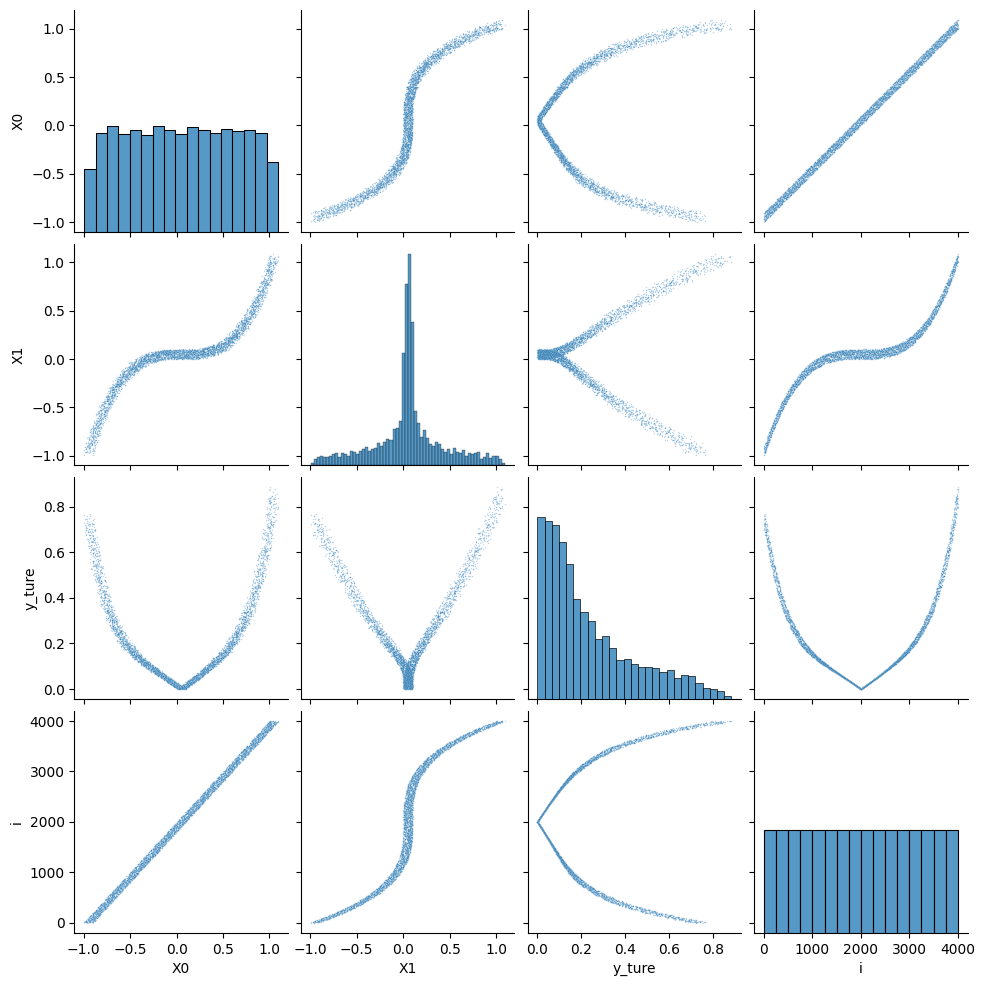

In [632]:
# put your inputs and outputs together in one DataFrame
i = np.arange(1, X.shape[0]+1)

df = pd.DataFrame(X, columns=[f"X{i}" for i in range(X.shape[1])])
df["y_ture"] = y_true if y_true.ndim == 1 else y_true[:,0]
df["i"] = i

# make the pairplot
sns.pairplot(df,  plot_kws={"alpha": 0.3, "s": 1})

#### Train Model

In [633]:
history = model.fit(X_train, y_train, X_eval, y_eval, epochs=1000, batch_size=400, learning_rate=0.1)

[ 0.009  0.849 -0.134 ...  0.847  0.62   0.025]
Batch 0/3200: acc: 0.17980356798911953, val: 0.1752863988487522
[ 0.009  0.849 -0.135 ...  0.848  0.619  0.034]
Batch 400/3200: acc: 0.11294661479161558, val: 0.11027663344098938
[ 0.009  0.849 -0.135 ...  0.849  0.618  0.038]
Batch 800/3200: acc: 0.08158138349690165, val: 0.07887920789560944
[ 0.01   0.849 -0.135 ...  0.849  0.618  0.04 ]
Batch 1200/3200: acc: 0.06924202011757913, val: 0.06695022897081955
[ 0.01   0.849 -0.135 ...  0.848  0.618  0.04 ]
Batch 1600/3200: acc: 0.06352217216263727, val: 0.06180846395681622
[ 0.009  0.849 -0.134 ...  0.848  0.618  0.041]
Batch 2000/3200: acc: 0.05946360683443136, val: 0.058382643012220695
[ 0.009  0.849 -0.134 ...  0.848  0.617  0.042]
Batch 2400/3200: acc: 0.05592973177669134, val: 0.056189786584011525
[ 0.009  0.849 -0.134 ...  0.848  0.617  0.042]
Batch 2800/3200: acc: 0.053311506371232796, val: 0.05365751477717163
Epoch 1/1000 [=........................]
loss: 0.0533, val_loss: 0.0537

[ 

KeyboardInterrupt: 

#### Evaluate Model

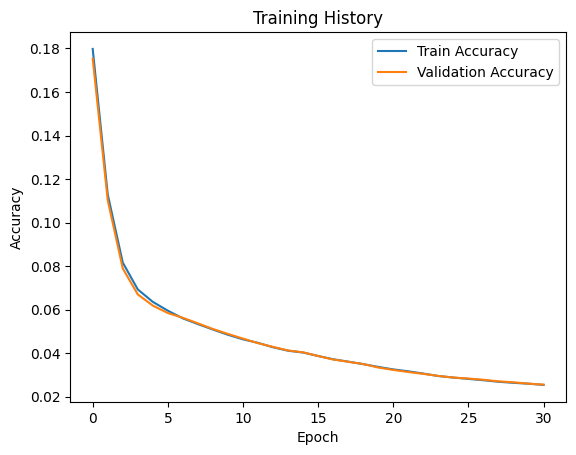

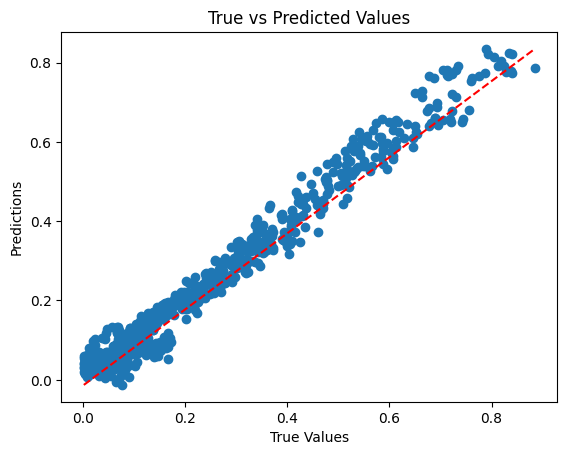

In [634]:
history = model.getHistory()
history.evaluate()

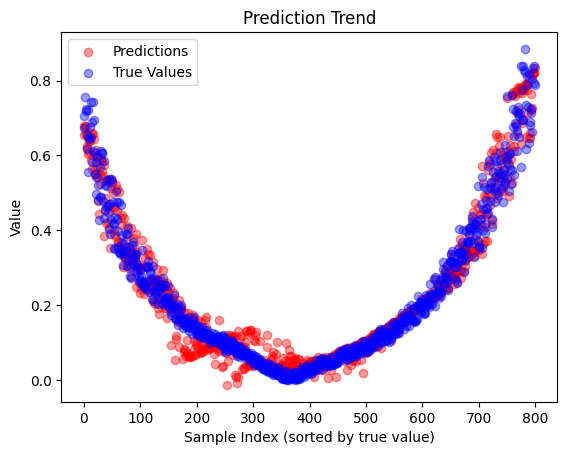

In [635]:
history.display_trend(ref="x", axis=0)

### Newton's GD

#### Setup LR models class

In [636]:
model = my_models.OptimizeNewtonLrModel()

test


In [637]:
model.add(50, input_shape=2)
model.add(30, activation="relu")
model.add(10, activation="relu")
model.add(10, activation="relu")
model.add(5)
model.add(1)

In [638]:
model.total_params()

2161

#### Load dataset

In [639]:
sample_dim = 4000
input_dim = 2
output_dim = 1
split_ration = 0.8

# Generate some linear sample_dim data
# linear [sample_dim_dim, 1]
linear = np.linspace(-1, 1, sample_dim).reshape(-1, 1)

# z [sample_dim, output_dim]
y_true = np.pow(linear,5)*0.5 + np.pow(linear, 1)*0.3 + np.pow(linear,3)*np.random.rand(sample_dim,output_dim)*0.1

y_true = np.abs(y_true)

# X [sample_dim, input_dim]
X = np.column_stack((linear, np.pow(linear, 3))).reshape(sample_dim, input_dim)+ np.random.rand(sample_dim,input_dim)*0.1

# Split dataset
X_train, y_train, X_eval, y_eval = dataUtils.split_data(X, y_true, split_ration)
y_pred = np.random.rand(y_eval.shape[0], y_eval.shape[1])


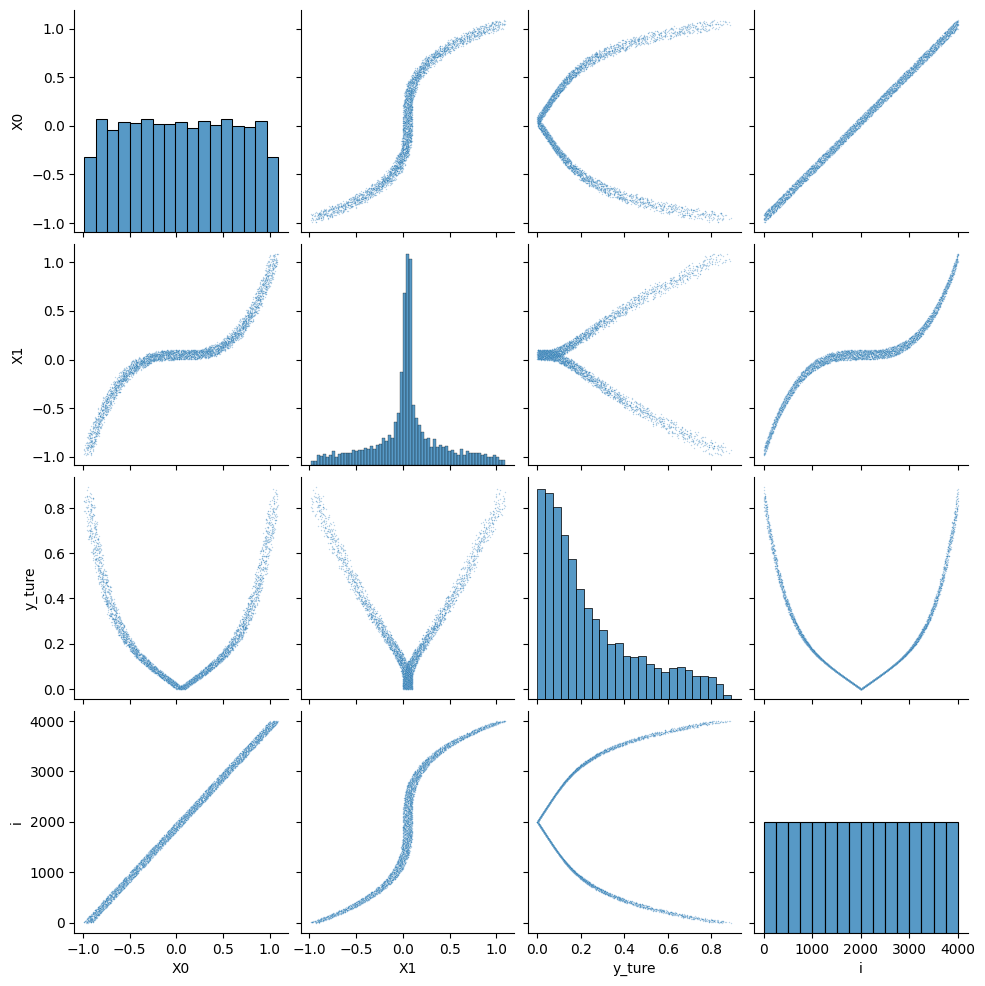

In [640]:
# put your inputs and outputs together in one DataFrame
i = np.arange(1, X.shape[0]+1)

df = pd.DataFrame(X, columns=[f"X{i}" for i in range(X.shape[1])])
df["y_ture"] = y_true if y_true.ndim == 1 else y_true[:,0]
df["i"] = i

# make the pairplot
sns.pairplot(df,  plot_kws={"alpha": 0.3, "s": 1})

#### Train Model

In [641]:
history = model.fit(X_train, y_train, X_eval, y_eval, epochs=5, batch_size=256)

Batch 0/3200: acc: 0.34674710426793337, val: 0.350965336600255
Batch 256/3200: acc: 0.3420156661524594, val: 0.3462228810770948
Batch 512/3200: acc: 0.3242147864511598, val: 0.3251650071572901
Batch 768/3200: acc: 0.31174899912597526, val: 0.3123058519284239
Batch 1024/3200: acc: 0.2722763036126251, val: 0.2741669817834122
Batch 1280/3200: acc: 0.2403902890967211, val: 0.24133030851753554
Batch 1536/3200: acc: 0.24219573001312317, val: 0.24188558001618568
Batch 1792/3200: acc: 0.20169094139228463, val: 0.19937643055345292
Batch 2048/3200: acc: 0.19663316854594295, val: 0.19481562835151273
Batch 2304/3200: acc: 0.18695065742113967, val: 0.18543752406255845
Batch 2560/3200: acc: 0.17388949914223445, val: 0.17094829351705287
Batch 2816/3200: acc: 0.1727485321102521, val: 0.16965455909473956
Batch 3072/3200: acc: 0.1477197921403752, val: 0.1440008567037872
Epoch 1/5 [=........................]
loss: 0.1477, val_loss: 0.1440

Batch 0/3200: acc: 0.12069036886624109, val: 0.11994753294967986


#### Evaluate Model

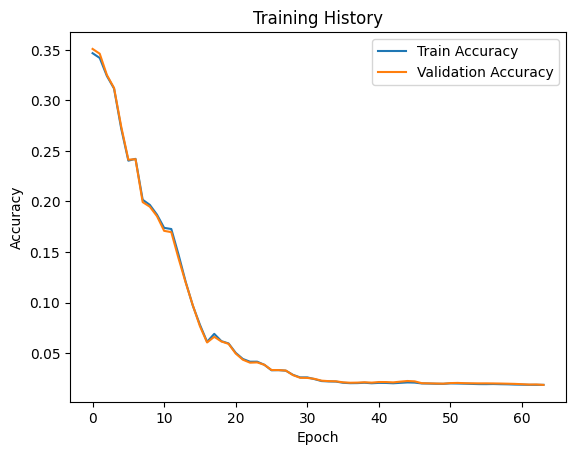

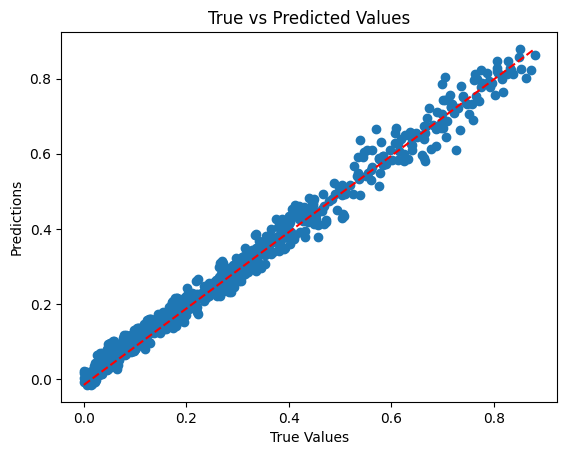

In [642]:
history.evaluate()

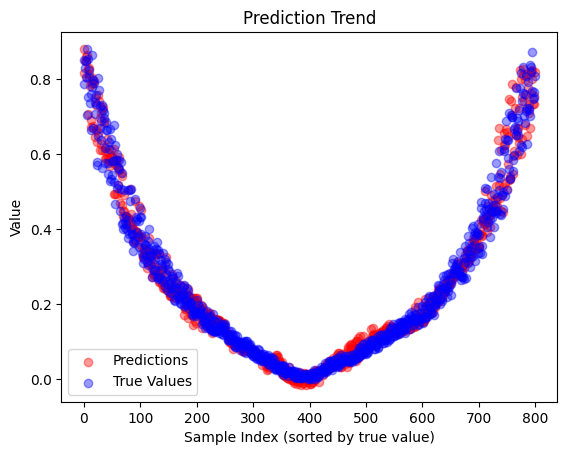

In [643]:
history.display_trend(ref="x", axis=0)